In [62]:
import time
import pandas as pd
import numpy as np
from logistic_regression import LogRegCCD
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

def shuffle(X, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    return X[indices], y[indices]


def generate_scheme_1(n, p, a):
    y = np.random.randint(0, 2, n)
    n_0 = len(y[y == 0])
    X_0 = np.random.normal(loc=0, scale=1, size=(n_0, p))
    X_1 = np.random.normal(loc=a, scale=1, size=(n - n_0, p))
    X = np.concatenate((X_0, X_1))
    y = np.concatenate((y[y == 0], y[y == 1]))
    X, y = shuffle(X, y)
    return X, y

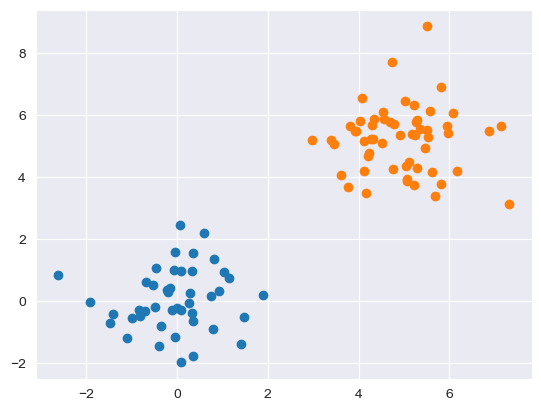

In [63]:
n = 100
n_features = 2
n_classes = 2
alpha = 0.9

X, y = generate_scheme_1(n, n_features, 5)

# linearly separable classes
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0])
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1])
plt.show()

In [64]:
lr = LogRegCCD()

iterations = 100
alpha = 0
lmbda = 0
lr.fit(iterations, X, y, alpha, lmbda)
print(f"beta: {lr.beta}")
# for linear separability coefficients values do not converge (high values)

y_pred = lr.predict(X)
accuracy = accuracy_score(y, y_pred)
print(accuracy)

beta: [-51.93116859   8.79929443  11.06010379]
1.0


In [65]:
# example dataset
df = pd.read_csv(r'datasets/parkinson/df_parkinson.csv')
X, y = df.iloc[:,:-1].values, df.iloc[:,-1:].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [66]:
# comparison between regularization and no regularization
alpha = 0.9

lr_reg = LogRegCCD()
lambda_max = lr_reg.compute_lambda_max(X_train, y_train, alpha)
print(f"lambda_max: {lambda_max}")

lmbda = 1
iterations = 20

start_time = time.time()
lr_reg.fit(iterations, X_train, y_train, alpha, lmbda)
end_time = time.time()
# print(f"beta: {lr_reg.beta}")
print(f"runtime: {end_time - start_time}")

y_pred = lr_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

lambda_max: 80.72216744715651
runtime: 4.006840944290161
0.8333333333333334


In [67]:
lr_no_reg = LogRegCCD()

start_time = time.time()
lr_no_reg.fit(iterations, X_train, y_train, 0, 0)
end_time = time.time()
# print(f"beta: {lr_no_reg.beta}")
print(f"runtime: {end_time - start_time}")

y_pred = lr_no_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# for lambda=0 the algorithm's results are worse
# time of computations is longer too

runtime: 7.091806173324585
0.8166666666666667


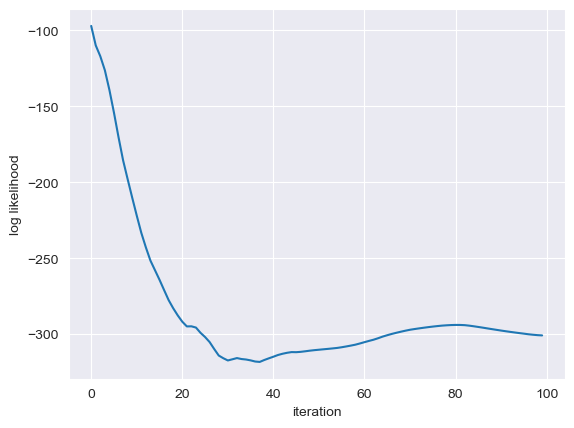

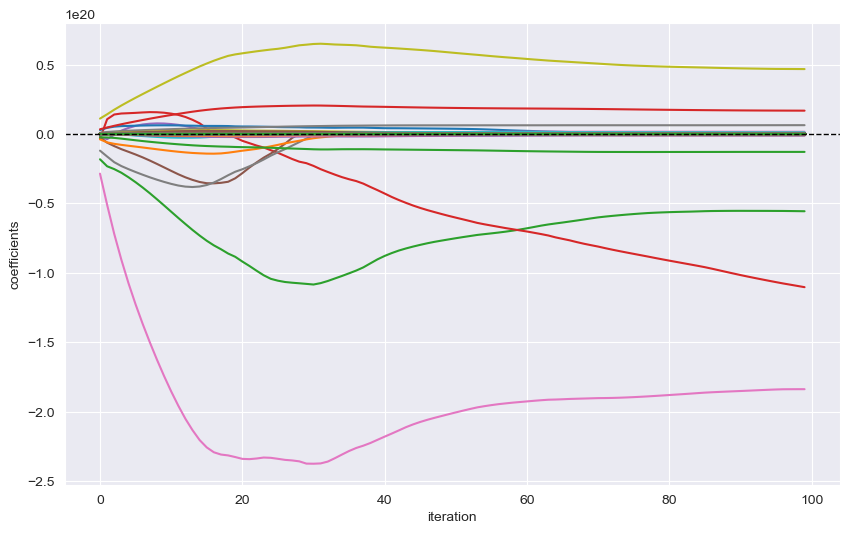

In [68]:
# likelihood values and coefficients
def log_likelihood(y, p):
    p = np.clip(p, 1e-10, 1 - 1e-10)
    log_likelihood_value = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    return log_likelihood_value

lr = LogRegCCD()

n = 100
iterations = 1
alpha = 0.9
lmbda = 0.01 # fixed lambda

likelihood_values = []
coefficient_values = []

for i in range(n):
    lr.fit(iterations, X_train, y_train, alpha, lmbda, adjust_beta=True)
    p_test = lr.predict_proba(X_test)
    ll = log_likelihood(y_test, p_test)
    likelihood_values.append(ll)
    coefficient_values.append(lr.beta.copy())
    lr._scale_beta_back() # for warm start

x_axis = np.arange(n) * iterations
plt.plot(x_axis, likelihood_values)
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x_axis, coefficient_values)
plt.xlabel("iteration")
plt.ylabel("coefficients")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

# after some iterations, coefficients stabilize

In [69]:
# comparison with l1 penalty

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score, precision_recall_curve, auc

lmbda = 1
alpha = 1
iterations = 100

X_train_std = lr._initialize(X_train)
X_test_std = lr._initialize(X_test)

custom_lr = LogRegCCD()
custom_lr.fit(iterations, X_train, y_train, alpha, lmbda)
y_prob_cdd = custom_lr.predict_proba(X_test)

test_acc_ccd = custom_lr.validate(X_test, y_test, 'balanced_accuracy')
test_roc_ccd = custom_lr.validate(X_test, y_test, 'roc_auc')
test_f1_cdd = custom_lr.validate(X_test, y_test, 'f1')

precision_cdd, recall_cdd, _ = precision_recall_curve(y_test, y_prob_cdd)
test_rp_cdd = auc(recall_cdd, precision_cdd)

sklearn_lr = LogisticRegression(solver="liblinear", penalty="l1", random_state=42, C=1)
sklearn_lr.fit(X_train_std, y_train)
y_pred_sklearn = sklearn_lr.predict(X_test_std)
y_prob_sklearn = sklearn_lr.predict_proba(X_test_std)[:, 1]

test_acc_sklearn = balanced_accuracy_score(y_test, y_pred_sklearn)
test_roc_sklearn = roc_auc_score(y_test, y_prob_sklearn)
test_f1_sklearn = f1_score(y_test, y_pred_sklearn)

precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_test, y_prob_sklearn)
test_rp_sklearn = auc(recall_sklearn, precision_sklearn)

In [70]:
print(f"test acc: {np.mean(test_acc_ccd)}, {np.mean(test_acc_sklearn)}")
print(f"test roc: {np.mean(test_roc_ccd)}, {np.mean(test_roc_sklearn)}")
print(f"test f1: {np.mean(test_f1_cdd)}, {np.mean(test_f1_sklearn)}")
print(f"test precision: {np.mean(precision_cdd)}, {np.mean(precision_sklearn)}")
print(f"test recall: {np.mean(recall_cdd)}, {np.mean(recall_sklearn)}")
print(f"test auc: {np.mean(test_rp_cdd)}, {np.mean(test_rp_sklearn)}")


test acc: 0.7415639195327709, 0.741239454899416
test roc: 0.8341985723556132, 0.854315379623621
test f1: 0.8880866425992779, 0.8791208791208791
test precision: 0.9033021493184522, 0.9191460645223659
test recall: 0.584934443803084, 0.5900470025562793
test auc: 0.9228666209484657, 0.9434160662309287


In [71]:
# number of features selected
print(f"custom model: {len(custom_lr.beta != 0)}")
print(f"sklearn model: {len(sklearn_lr.coef_[0] != 0) + 1 if sklearn_lr.intercept_ != 0 else 0}")

custom model: 313
sklearn model: 314
